In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
import re
import sklearn
import time
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda, munge
from datsci import kaggle as kg

In [190]:
FILE_TRAIN                               = 'data/train.csv'
FILE_TRAIN_DEDUP                         = 'data/train.dedup.csv'
FILE_TRAIN_DEDUP_ONEHOT                  = 'data/train.dedup.onehot.csv'
FILE_TRAIN_DEDUP_ONEHOT_NA               = 'data/train.dedup.onehot.na.csv'
FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEAN   = 'data/train.dedup.onehot.na.impute_mean.csv'
FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN = 'data/train.dedup.onehot.na.impute_median.csv'
FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_FREQ   = 'data/train.dedup.onehot.na.impute_freq.csv'
FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT     = 'data/train.dedup.onehot.na.onehotint.csv'

FILE_TEST                                = 'data/test.csv'
FILE_TEST_DEDUP                          = 'data/test.dedup.csv'
FILE_TEST_DEDUP_ONEHOT                   = 'data/test.dedup.onehot.csv'
FILE_TEST_DEDUP_ONEHOT_NA                = 'data/test.dedup.onehot.na.csv'
FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEAN    = 'data/test.dedup.onehot.na.impute_mean.csv'
FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN  = 'data/test.dedup.onehot.na.impute_median.csv'
FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_FREQ    = 'data/test.dedup.onehot.na.impute_freq.csv'
FILE_TEST_DEDUP_ONEHOT_NA_ONEHOTINT      = 'data/test.dedup.onehot.na.onehotint.csv'

FILE_SAMPLE_SUBMIT                       = 'data/sample_submission.csv'

TARGET_COL                               = 'TARGET'

In [226]:
def get_sizes(train_csv, test_csv):
    df = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv, index_col='ID')
    train_rows, train_cols = df.shape
    test_rows, test_cols = df_test.shape
    return train_rows, train_cols, test_rows, test_cols


data_shapes = []
for s, train_csv, test_csv in [
    ('raw',           FILE_TRAIN,                               FILE_TEST),
    ('dedup',         FILE_TRAIN_DEDUP,                         FILE_TEST_DEDUP),
    ('bin onehot',    FILE_TRAIN_DEDUP_ONEHOT,                  FILE_TEST_DEDUP_ONEHOT),
    ('NaN',           FILE_TRAIN_DEDUP_ONEHOT_NA,               FILE_TEST_DEDUP_ONEHOT_NA),
    ('impute mean',   FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEAN,   FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEAN),
    ('impute median', FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN, FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN),
    ('impute freq',   FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_FREQ,   FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_FREQ),
    ('onehot int',    FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT,     FILE_TEST_DEDUP_ONEHOT_NA_ONEHOTINT),]:
    data_shapes.append((s,) + get_sizes(train_csv, test_csv))
pd.DataFrame(data_shapes, columns=['stage', 'train rows', 'train cols', 'test rows', 'test cols'])

,stage,train rows,train cols,test rows,test cols
0,raw,76020,371,75818,369
1,dedup,71213,307,75818,306
2,bin onehot,71213,363,75818,362
3,NaN,71213,357,75818,356
4,impute mean,71213,357,75818,356
5,impute median,71179,357,75818,356
6,impute freq,71179,357,75818,356
7,onehot int,71213,398,75818,397


## Remove duplicates

In [3]:
def dedup():
    # Read data from file
    df = pd.read_csv(FILE_TRAIN, index_col='ID')

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # Remove constant columns
    df.drop(eda.find_const_cols(df), axis=1, inplace=True)
    
    # Remove duplicate columns and then rows again
    df = munge.remove_duplicates(df.T).T.drop_duplicates()
    
    # Write to file
    df.to_csv(FILE_TRAIN_DEDUP, index=False)
    
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)

    # Read in test
    df_test = pd.read_csv(FILE_TEST, index_col='ID')
    df_test[feature_cols].to_csv(FILE_TEST_DEDUP)
    
    
if not os.path.exists(FILE_TRAIN_DEDUP):
    dedup()

## One-hot encode binary features

In [4]:
def one_hot_binary():
    df = pd.read_csv(FILE_TRAIN_DEDUP)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test = pd.read_csv(FILE_TEST_DEDUP, index_col='ID')
    
    binary_cols = [c for c in df.columns if c[:4] == 'ind_']
    
    # Convert to int
    for c in binary_cols:
        df[c] = df[c].values.astype(int)
    
    df_onehot = munge.hash_features(df, columns=binary_cols)
    df_test_onehot = munge.hash_features(df_test, columns=binary_cols)
    
    df_onehot.to_csv(FILE_TRAIN_DEDUP_ONEHOT, index=False)
    df_test_onehot.to_csv(FILE_TEST_DEDUP_ONEHOT)


if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT):
    one_hot_binary()

## Process known NaNs

https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/111360#post111360

In [5]:
def process_known_nans():
    df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT, index_col='ID')
    
    # Var3
    df['var3'] = df.var3.replace(-999999, np.nan)
    df_test['var3'] = df_test.var3.replace(-999999, np.nan)
    
    # Find integer features with null values
    for c in feature_cols:
        if df[c].describe()['max'] == 9999999999:
            df[c] = df[c].replace(9999999999, np.nan)
            df_test[c] = df_test[c].replace(9999999999, np.nan)
    
    # Remove constant columns
    df.drop(eda.find_const_cols(df), axis=1, inplace=True)

    # Remove duplicate columns and then rows again
    df = munge.remove_duplicates(df.T).T.drop_duplicates()
    
    # Write to file
    df.to_csv(FILE_TRAIN_DEDUP_ONEHOT_NA, index=False)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test[feature_cols].to_csv(FILE_TEST_DEDUP_ONEHOT_NA)
    
    
if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT_NA):
    process_known_nans()

## Fill in null values

In [225]:
from sklearn.preprocessing import Imputer

def impute_null_vals(train_csv, test_csv, train_out_csv, test_out_csv, strategy='mean'):

    # Read in data
    df = pd.read_csv(train_csv)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test = pd.read_csv(test_csv, index_col='ID')

    # Impute using combined (train + test) datasets
    df_combined = df[feature_cols].append(df_test[feature_cols])
    imputer = Imputer(missing_values='NaN', strategy=strategy, axis=0, verbose=0, copy=False).fit(df_combined)
    df[feature_cols] = imputer.transform(df[feature_cols])
    df_test[feature_cols] = imputer.transform(df_test[feature_cols])
    
    # Remove duplicate columns and rows
    df = munge.remove_duplicates(df.T).T.drop_duplicates()
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test = df_test[feature_cols]
    
    # Write to file
    df.to_csv(train_out_csv, index=False)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test[feature_cols].to_csv(test_out_csv)
    
    
if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEAN):
    impute_null_vals(
        FILE_TRAIN_DEDUP_ONEHOT_NA,               FILE_TEST_DEDUP_ONEHOT_NA,
        FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEAN,   FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEAN,
        strategy='mean'
    )
    
if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN):
    impute_null_vals(
        FILE_TRAIN_DEDUP_ONEHOT_NA,               FILE_TEST_DEDUP_ONEHOT_NA,
        FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN, FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN,
        strategy='median'
    )
    
if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_FREQ):
    impute_null_vals(
        FILE_TRAIN_DEDUP_ONEHOT_NA,               FILE_TEST_DEDUP_ONEHOT_NA,
        FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_FREQ,   FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_FREQ,
        strategy='most_frequent'
    )

## Turn some of the integer columns to categorical features

In [220]:
def one_hot_int():
    df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA)
    feature_cols = list(df.columns)
    feature_cols.remove(TARGET_COL)
    df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA, index_col='ID')
    
    # Ignore already-one hot encoded columns
    int_cols = feature_cols[:]
    for c in feature_cols:
        if c[:6] == 'onehot':
            int_cols.remove(c)
           
    # Fine categorical columns
    categorical_cols = eda.find_categorical_columns(df[int_cols], df_test)
    
    # Convert non-null value containing columns to integers
    for c, n in categorical_cols:
        # Dont turn null values to int
        if c not in {'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var33_in_1y3'}:
            df[c] = df[c].values.astype(int)

    # One-hot encode the categorical columns
    catcols = list(map(lambda t: t[0], categorical_cols))
    df_onehot = munge.hash_features(df, columns=catcols)
    df_test_onehot = munge.hash_features(df_test, columns=catcols)

    # Remove duplicate columns and rows
    df_onehot = munge.remove_duplicates(df_onehot.T).T.drop_duplicates()
    feature_cols = list(df_onehot.columns)
    feature_cols.remove(TARGET_COL)
    df_test_onehot = df_test_onehot[feature_cols]
    
    # Save to file
    df_onehot.to_csv(FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT, index=False)
    df_test_onehot.to_csv(FILE_TEST_DEDUP_ONEHOT_NA_ONEHOTINT)

    
if not os.path.exists(FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT):
    one_hot_int()

## Find weird columns and delete them

#### Starting with binary columns

In [169]:
len([c for c, n in categorical_cols if n==2])

72

In [157]:
binary_cols_01 = []
for c, n in categorical_cols:
    if n == 2 and (set(df[c].unique()) == {0, 1} or set(df[c].unique()) == {0.0, 1.0}):
        binary_cols_01.append(c)

In [158]:
len(binary_cols_01)

54

In [154]:
set(binary_cols2) - set(binary_cols_01)

{'ind_var30', 'ind_var5'}

In [155]:
df.ind_var30.value_counts()

1.0    53605
0.0    17608
Name: ind_var30, dtype: int64

In [156]:
df_test.ind_var30.value_counts()

1    55648
0    20170
Name: ind_var30, dtype: int64

In [46]:
# Check binary cols that are weird
weird_binary_cols = []
for c, n in categorical_cols:
    if n == 2:
        if set(df[c].unique()) != {0, 1}:
            weird_binary_cols.append(c)
weird_binary_cols

['num_var6_0',
 'num_var6',
 'num_var8',
 'num_var18_0',
 'num_var20_0',
 'num_var20',
 'num_var34_0',
 'num_var40',
 'delta_imp_amort_var18_1y3',
 'delta_imp_amort_var34_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_trasp_var33_out_1y3',
 'num_meses_var13_medio_ult3',
 'num_reemb_var13_ult1',
 'num_trasp_var33_in_hace3',
 'num_trasp_var33_out_ult1']

In [47]:
x = 8
print(weird_binary_cols[x])
pd.DataFrame({'train': df[weird_binary_cols[x]].value_counts(), 'test': df_test[weird_binary_cols[x]].value_counts()})

delta_imp_amort_var18_1y3


,test,train
0,75817,71211
9999999999,1,2


In [48]:
delete_cols = ['delta_imp_amort_var18_1y3']

In [49]:
x = 9
print(weird_binary_cols[x])
pd.DataFrame({'train': df[weird_binary_cols[x]].value_counts(), 'test': df_test[weird_binary_cols[x]].value_counts()})

delta_imp_amort_var34_1y3


,test,train
0,75816,71211
9999999999,2,2


In [50]:
delete_cols.append('delta_imp_amort_var34_1y3')

In [51]:
x = 10
print(weird_binary_cols[x])
pd.DataFrame({'train': df[weird_binary_cols[x]].value_counts(), 'test': df_test[weird_binary_cols[x]].value_counts()})

delta_imp_reemb_var13_1y3


,test,train
0,75791,71175
9999999999,27,38


In [52]:
delete_cols.append('delta_imp_reemb_var13_1y3')

In [53]:
x = 11
print(weird_binary_cols[x])
pd.DataFrame({'train': df[weird_binary_cols[x]].value_counts(), 'test': df_test[weird_binary_cols[x]].value_counts()})

delta_imp_trasp_var33_out_1y3


,test,train
0,75817,71212
9999999999,1,1


In [63]:
delete_cols.append('delta_imp_trasp_var33_out_1y3')

In [70]:
delete_cols

['delta_imp_amort_var18_1y3',
 'delta_imp_amort_var34_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_trasp_var33_out_1y3']

#### Trinary columns

In [72]:
trinary_cols = [c for c, n in categorical_cols if n == 3]
trinary_cols

['num_var1_0',
 'num_var1',
 'num_var8_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var24',
 'num_var33',
 'num_var40_0',
 'num_var44_0',
 'delta_imp_trasp_var33_in_1y3',
 'num_meses_var29_ult3',
 'num_trasp_var33_in_ult1']

In [76]:
x = 3
print(trinary_cols[x])
pd.DataFrame({'train': df[trinary_cols[x]].value_counts(), 'test': df_test[trinary_cols[x]].value_counts()})

num_var13_corto_0


,test,train
0,72521,67949
3,3270,3226
6,27,38


In [79]:
zero_three_six = {0, 3, 6}
for c in trinary_cols:
    if set(df[c].unique()) != zero_three_six:
        print(c)

delta_imp_trasp_var33_in_1y3
num_meses_var29_ult3


In [80]:
df['delta_imp_trasp_var33_in_1y3'].value_counts()

 0.000000e+00    71202
-1.000000e+00        6
 1.000000e+10        5
Name: delta_imp_trasp_var33_in_1y3, dtype: int64

In [81]:
df_test['delta_imp_trasp_var33_in_1y3'].value_counts()

 0             75799
 9999999999       12
-1                 7
Name: delta_imp_trasp_var33_in_1y3, dtype: int64

#### Quaternary cols

In [87]:
quaternary_cols = [c for c, n in categorical_cols if n == 4]
quaternary_cols

['num_meses_var8_ult3']

In [92]:
df['num_meses_var8_ult3'].value_counts()

0.0    68998
2.0      910
1.0      830
3.0      475
Name: num_meses_var8_ult3, dtype: int64

In [93]:
df_test['num_meses_var8_ult3'].value_counts()

0    73504
1      917
2      915
3      482
Name: num_meses_var8_ult3, dtype: int64

In [94]:
eda.find_n_nary_cols(df, n=4)

['num_var12',
 'num_var14',
 'num_var24_0',
 'num_var33_0',
 'delta_num_aport_var33_1y3',
 'imp_var7_emit_ult1',
 'imp_venta_var44_hace3',
 'num_aport_var33_hace3',
 'num_compra_var44_hace3',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var13_largo_ult3',
 'num_meses_var17_ult3',
 'num_meses_var33_ult3',
 'num_meses_var39_vig_ult3',
 'num_meses_var44_ult3',
 'saldo_medio_var29_ult1',
 'saldo_medio_var29_ult3']

In [95]:
df.num_var12.value_counts()

0.0     67760
3.0      3415
6.0        37
15.0        1
Name: num_var12, dtype: int64

In [96]:
df_test.num_var12.value_counts()

0    72379
3     3414
6       25
Name: num_var12, dtype: int64

In [97]:
df.num_var42_0.value_counts()

3.0      65440
6.0       5121
0.0        436
9.0        203
12.0         9
15.0         2
114.0        1
18.0         1
Name: num_var42_0, dtype: int64

In [15]:
unique_hists = eda.get_hist_unique_col_values_many([df, df_test[feature_cols]], ['train dedup', 'test'], exclude_nan=True)

In [17]:
unique_hists.head()

,train dedup,test
1,NaN,9.0
2,86.0,76.0
3,26.0,26.0
4,20.0,17.0
5,13.0,13.0


In [6]:
unique_hists.head()

,train dedup,test
1,NaN,9.0
2,86.0,76.0
3,26.0,26.0
4,20.0,17.0
5,13.0,13.0


In [51]:
df['num_compra_var44_ult1'].value_counts()

0.0     71129
3.0        46
6.0        18
9.0         6
24.0        4
15.0        3
12.0        3
18.0        2
39.0        1
21.0        1
Name: num_compra_var44_ult1, dtype: int64

### Remove bad columns, and compute one-hot encoding

In [104]:
foo.drop('a', axis=1, inplace=True)

In [140]:
pd.get_dummies(foo.b, prefix='b', prefix_sep='_')

,b_4,b_5,b_6
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [136]:
foo

,b,c
0,4,d
1,5,e
2,6,f


In [106]:
munge.hash_features(foo, columns=['c'])

,b,c_d,c_e,c_f
0,4,1.0,0.0,0.0
1,5,0.0,1.0,0.0
2,6,0.0,0.0,1.0


In [125]:
delete_cols

['delta_imp_amort_var18_1y3',
 'delta_imp_amort_var34_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_trasp_var33_out_1y3']

In [128]:
len(categorical_cols)

83

In [134]:
categorical_cols_filterd = [c for c, n in categorical_cols if c not in delete_cols]

In [135]:
len(categorical_cols_filterd)

79

In [111]:
df.drop(delete_cols, axis=1, inplace=True)
df_test.drop(delete_cols, axis=1, inplace=True)

## Find NaNs

### Data processing thread
https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/111360#post111360

### Find columns with extreme values

In [46]:
# Find columns with extreme values
extreme_cols = eda.find_extreme_cols(df, T=10000)

In [22]:
len(extreme_cols)

272

### var3

In [16]:
df[df.var3 == -999999].shape

(107, 307)

In [39]:
df['var3'] = df.var3.replace(-999999, np.nan)

In [27]:
df.var3.describe()

count    71106.000000
mean         2.766053
std          9.767036
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        238.000000
Name: var3, dtype: float64

In [28]:
df[df.var3 == 238].shape

(1, 307)

In [30]:
df.var3.dropna().sort_values()[-3:]

24978    231.0
6791     235.0
66940    238.0
Name: var3, dtype: float64

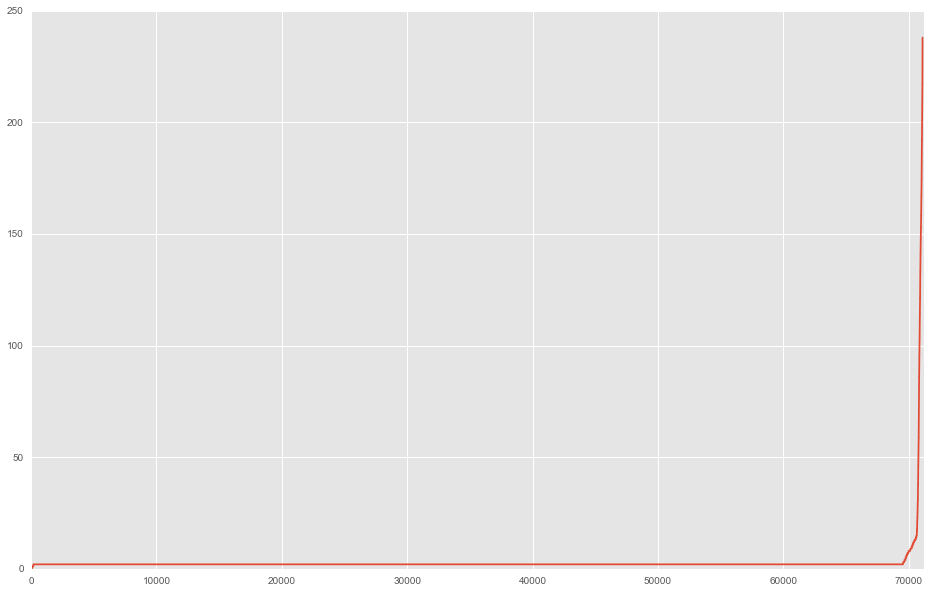

In [33]:
pd.Series(df.var3.sort_values().values).plot()

In [40]:
df[extreme_cols[1]].describe()

count     71213.000000
mean         92.027471
std        1668.207086
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      210000.000000
Name: imp_ent_var16_ult1, dtype: float64

In [ ]:
df.imp_ent_var16_ult1.